# Xarray interface for neoclassical transport

## `SymbolicEquilibrium`

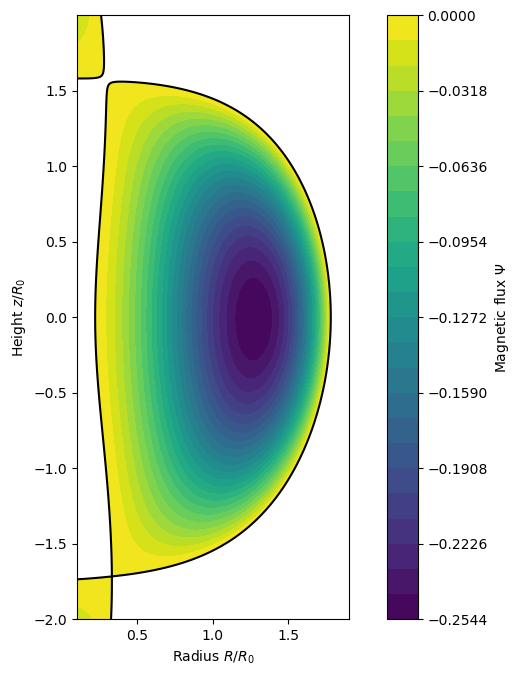

In [1]:
from plasmaboundaries import NSTX_single_null

NSTX_single_null

NSTX_Bt0 = 0.3 * u.T
NSTX_R0 = 0.8 * u.m
NSTX_a0 = 0.64 * u.m
NSTX_I = 1 * u.MA
from plasmapy.plasma.symbolicequilibrium import SymbolicEquilibrium

params = {"aspect_ratio": 1.25, "A": -0.05, "elongation": 2, "triangularity": 0.3}
# TODO this is still not taken in

eq = SymbolicEquilibrium(
    **NSTX_single_null,
    B0=NSTX_Bt0.si.value,  # TODO handle quantity input
    config="single-null"
)
rminmaxstep = (
    0.1,
    1.9,
    0.001,
)  # these definitely, unfortunately, need to be moved into SymbolicEquilibrium
zminmaxstep = (-2, 2, 0.001)
eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep);

In [ ]:
import astropy.units as u
import numpy as np


In [2]:
import xarray

In [3]:
rho = np.linspace(0, 1, 50)

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

## Multiple flux surfaces - radial grid

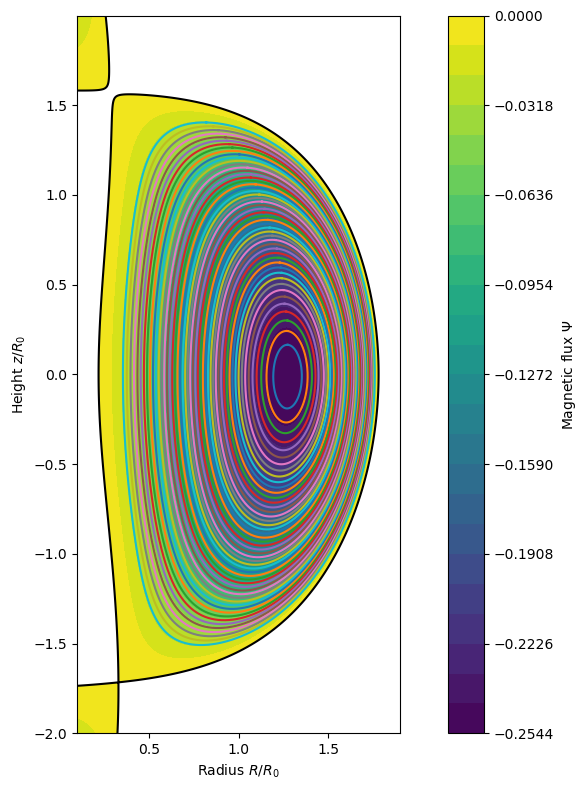

In [4]:
ax = eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep)
psi = np.linspace(-0.25, -0.023, 50)
surfaces = list(
    eq.get_multiple_flux_surfaces(psi, rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep)
)  # TODO handle multiple contours; just find closed ones
for fs in surfaces:
    fs.plot(ax)
ax.legend().remove()
plt.tight_layout()
# plt.savefig("/home/dominik/Writing/blog/images/fluxsurfacegrid.png")

## `FlowCalculator`

In [5]:
surfaces[0]

FluxSurface(R=array([1.27394038, 1.27334778, 1.27234833, ..., 1.27534667, 1.27434722,
       1.27394038]), Z=array([0.16445875, 0.16449647, 0.16453253, ..., 0.16434116, 0.16443274,
       0.16445875]), psi=-0.25, Brvals=array([-0.03875354, -0.03874911, -0.03873553, ..., -0.03875775,
       -0.03875654, -0.03875354]), Bzvals=array([0.00184877, 0.00121277, 0.00013945, ..., 0.0033579 , 0.00228559,
       0.00184877]), Bphivals=array([0.29949229, 0.29963168, 0.29986704, ..., 0.29916205, 0.29939668,
       0.29949229]), Bprimervals=array([0.07284229, 0.05522852, 0.02546492, ..., 0.11449098, 0.08492156,
       0.07284229]), Bprimezvals=array([0.22379685, 0.22300461, 0.22152707, ..., 0.22542649, 0.22430493,
       0.22379685]), GradRho2=array([0.03775374, 0.03766123, 0.03753947, ..., 0.0380429 , 0.03782904,
       0.03775374]))

In [6]:
rho_to_surface = {rho: surfaces[i] for i, rho in enumerate(rho)};

In [7]:
rho = psi / psi.min()  # TODO
# also TODO my rho is already normalized

array([1.        , 0.98146939, 0.96293878, 0.94440816, 0.92587755,
       0.90734694, 0.88881633, 0.87028571, 0.8517551 , 0.83322449,
       0.81469388, 0.79616327, 0.77763265, 0.75910204, 0.74057143,
       0.72204082, 0.7035102 , 0.68497959, 0.66644898, 0.64791837,
       0.62938776, 0.61085714, 0.59232653, 0.57379592, 0.55526531,
       0.53673469, 0.51820408, 0.49967347, 0.48114286, 0.46261224,
       0.44408163, 0.42555102, 0.40702041, 0.3884898 , 0.36995918,
       0.35142857, 0.33289796, 0.31436735, 0.29583673, 0.27730612,
       0.25877551, 0.2402449 , 0.22171429, 0.20318367, 0.18465306,
       0.16612245, 0.14759184, 0.12906122, 0.11053061, 0.092     ])

In [8]:
import jax.numpy as jnp

In [9]:
from jax import grad, vmap

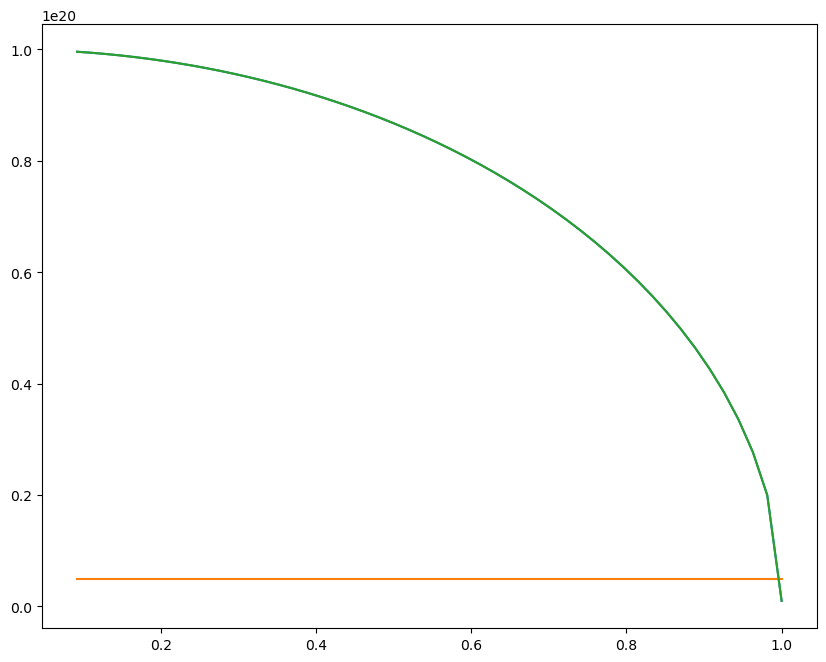

In [10]:
rhoj = jnp.array(rho)
T0 = 0.5 * (u.keV.to(u.eV))
Ta = 0.1 * T0


def T_i_func(rho, T0=T0, Ta=Ta):
    T_i = (T0 - Ta) * (
        1 - rho ** 2
    ) + Ta  # .to(u.K, equivalencies = u.temperature_energy())
    return T_i


T_i = T_i_func(rhoj)
assert T_i.min() > 0
T_e = T_i
ne_0 = 6.5e19  # * u.m**-3
ne_0 = 1e20
ne_a = 0.2 * ne_0  # * u.m**-3
ne_a = 1e18


def n_e_func(rho, ne_0=ne_0, ne_a=ne_a):
    n_e = (ne_0 - ne_a) * (1 - rho ** 2) ** 0.5 + ne_a
    return n_e


n_e = n_e_func(rhoj)
n_i = n_e  # TODO
n_C6 = np.full_like(n_e, 5e18)  # * u.m**-3)
plt.plot(rho, n_e)
plt.plot(rho, n_C6)
plt.plot(rho, n_i)

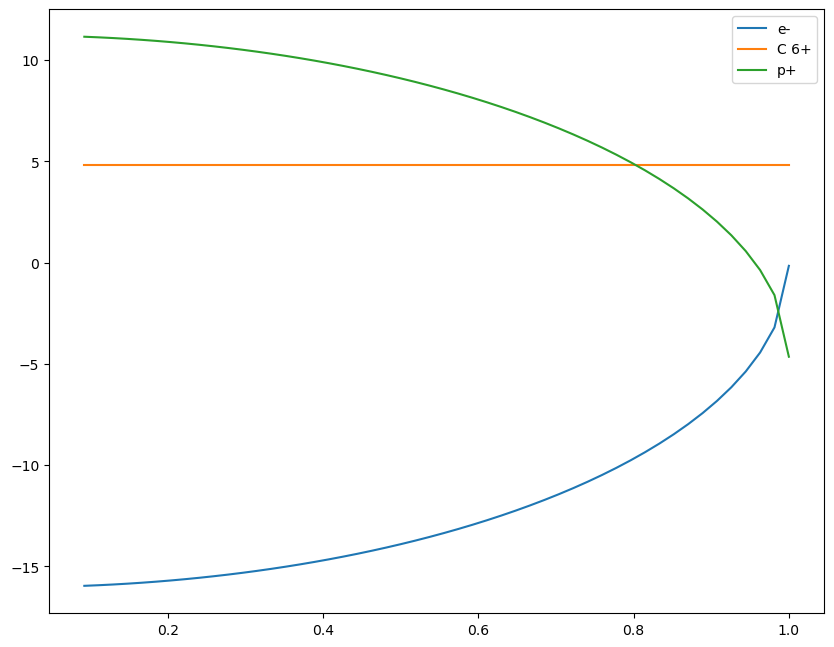

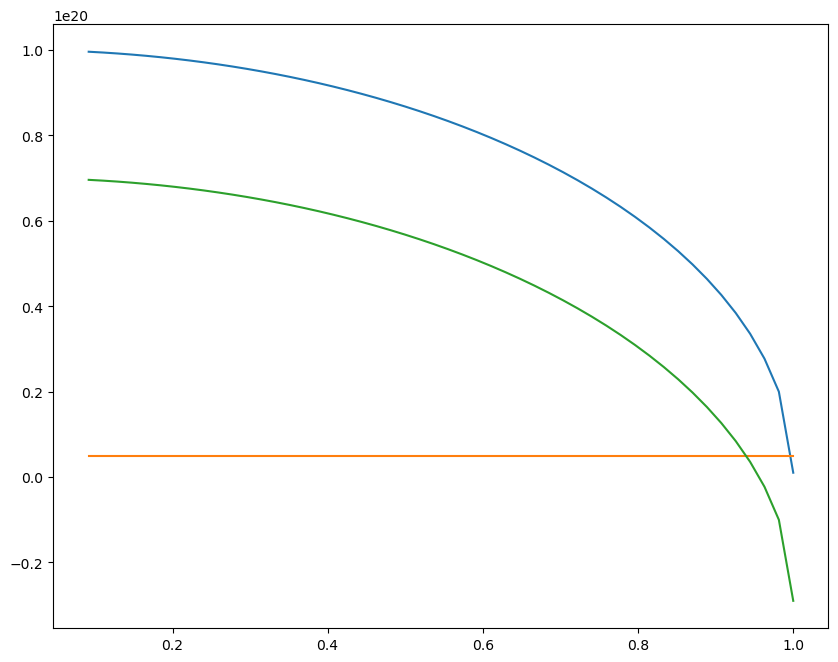

In [11]:
from astropy import constants

e_charge_density = -n_e * constants.e.si
C6_charge_density = n_C6 * 6 * constants.e.si
proton_charge_density = 0 - e_charge_density - C6_charge_density
plt.plot(rho, e_charge_density, label="e-")
plt.plot(rho, C6_charge_density, label="C 6+")
plt.plot(rho, proton_charge_density, label="p+")
plt.legend()
plt.figure()
n_i = proton_charge_density / constants.e.si
plt.plot(rho, n_e)
plt.plot(rho, n_C6)
plt.plot(rho, n_i)

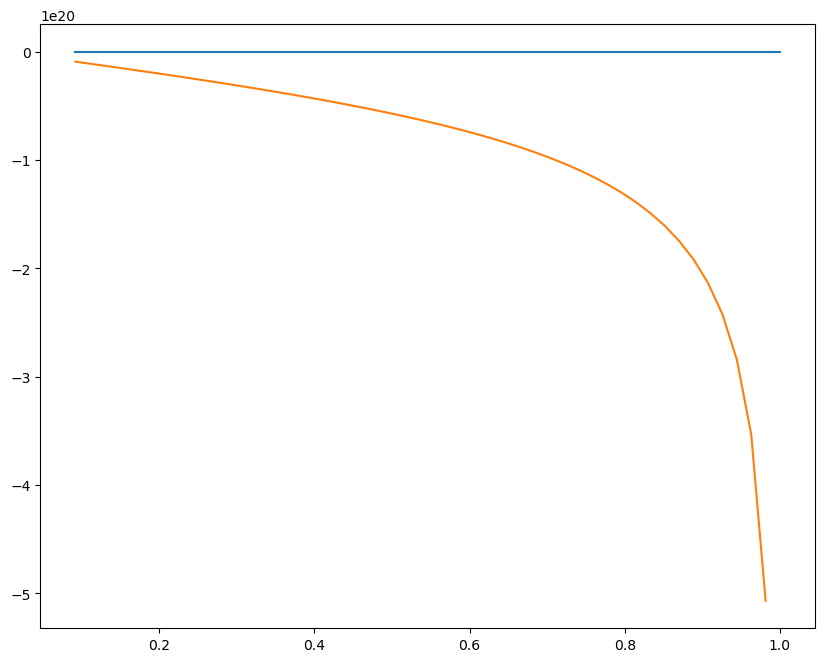

In [12]:
dTi = vmap(grad(T_i_func))(rho)
dn_e = vmap(grad(n_e_func))(rho)
plt.plot(rho, dTi)
plt.plot(rho, dn_e)

In [13]:
import xarray

dataset_H1 = xarray.Dataset(
    {
        "T": ("psi", T_i),
        "gradT": ("psi", dTi),
        "n": ("psi", n_e),
        "gradn": ("psi", dn_e),
    },
    coords={"psi": psi, "particle": "H 1+"},
    attrs={
        "T unit": u.eV,
        "n unit": u.m ** -3,
        "gradT unit": u.eV / u.m,
        "gradn unit": u.m ** -3 / u.m,
    },
)

dataset_C6 = xarray.Dataset(
    {
        "T": ("psi", T_i),
        "gradT": ("psi", dTi),
        "n": ("psi", n_C6),
        "gradn": ("psi", jnp.zeros_like(n_C6)),
    },
    coords={"psi": psi, "particle": "C 6+"},
    attrs={
        "T unit": u.eV,
        "n unit": u.m ** -3,
        "gradT unit": u.eV / u.m,
        "gradn unit": u.m ** -3 / u.m,
    },
)
dataset_e = xarray.Dataset(
    {
        "T": ("psi", T_e),
        "gradT": ("psi", dTi),
        "n": ("psi", n_e),
        "gradn": ("psi", dn_e),
    },
    coords={"psi": psi, "particle": "e-"},
    attrs={
        "T unit": u.eV,
        "n unit": u.m ** -3,
        "gradT unit": u.eV / u.m,
        "gradn unit": u.m ** -3 / u.m,
    },
)

dataset = xarray.concat([dataset_H1, dataset_C6, dataset_e], dim="particle")
dataset["rho"] = ("psi", rho)
dataset["charges"] = ("particle", [1, 6, -1])
dataset["charge_density"] = "psi", (dataset.charges * dataset.n).sum(dim="particle")
dataset

<xarray.Dataset>
Dimensions:         (particle: 3, psi: 50)
Coordinates:
  * psi             (psi) float64 -0.25 -0.2454 -0.2407 ... -0.02763 -0.023
  * particle        (particle) <U4 'H 1+' 'C 6+' 'e-'
Data variables:
    T               (particle, psi) float32 50.0 66.52 82.74 ... 494.5 496.2
    gradT           (particle, psi) float32 -900.0 -883.3 ... -99.48 -82.8
    n               (particle, psi) float32 1e+18 1.997e+19 ... 9.958e+19
    gradn           (particle, psi) float32 -inf -5.071e+20 ... -9.147e+18
    rho             (psi) float64 1.0 0.9815 0.9629 ... 0.1291 0.1105 0.092
    charges         (particle) int64 1 6 -1
    charge_density  (psi) float64 3e+19 3e+19 3e+19 3e+19 ... 3e+19 3e+19 3e+19
Attributes:
    T unit:      eV
    n unit:      1 / m3
    gradT unit:  eV / m
    gradn unit:  1 / m4

In [27]:
from tqdm import auto as tqdm

from plasmapy.transport.flows import FlowCalculator

fcs = []
import warnings

N = dataset.psi.size
assert N == len(surfaces)
for ρ, surface in tqdm.tqdm(zip(dataset.psi, surfaces), total=N):
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fcs.append(FlowCalculator.from_xarray_surface(dataset.sel(psi=ρ), surface))
    except ImportError as e:
        display(e)

  0%|          | 0/50 [00:00<?, ?it/s]

e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.


In [47]:
results = xarray.concat([fc.to_dataset() for fc in tqdm.tqdm(fcs)], dim="psi")
results = results.swap_dims({"psi": "rho"})
scaling = (fcs[0].bootstrap_current.unit / NSTX_Bt0).to(u.MA / u.m ** 2)
results = results.assign(
    bootstrap_current_normalized=results.bootstrap_current * scaling
)

  0%|          | 0/50 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:                       (particle: 3, rho: 50)
Coordinates:
  * particle                      (particle) <U4 'C 6+' 'H 1+' 'e-'
    psi                           (rho) float64 -0.25 -0.2454 ... -0.023
  * rho                           (rho) float64 1.0 0.9815 ... 0.1105 0.092
Data variables: (12/18)
    total_particle_flux           (rho, particle) float64 -1.989e+20 ... nan
    total_heat_flux               (rho, particle) float64 -5.29e+03 ... nan
    BP_particle_flux              (rho, particle) float64 -2.006e+20 ... nan
    BP_heat_flux                  (rho, particle) float64 -2.28e+03 ... nan
    CL_particle_flux              (rho, particle) float64 1.253e+18 ... nan
    CL_heat_flux                  (rho, particle) float64 -2.173e+03 ... nan
    ...                            ...
    gradT                         (rho, particle) float32 -900.0 ... -82.8
    n                             (rho, particle) float32 5e+18 ... 9.958e+19
    gradn                         (rho, particle) float32 0.0 ... -9.147e+18
    charges                       (rho, particle) int64 6 1 -1 6 1 ... -1 6 1 -1
    charge_density                (rho) float64 3e+19 3e+19 ... 3e+19 3e+19
    bootstrap_current_normalized  (rho) float64 -0.001295 0.06802 ... 0.01413

In [ ]:
results.bootstrap_current_normalized.plot.line()

In [ ]:
results.thermal_conductivity

In [ ]:
results.diffusion_coefficient.sel(particle="C 6+")

In [ ]:
results.diffusion_coefficient.plot.line(x="rho")
plt.xlim(0, 0.8)
plt.ylim(-10, 10)

In [ ]:
results.thermal_conductivity.plot.line(x="rho")

In [ ]:
results.total_particle_flux.plot.line(x="rho")

In [ ]:
results.CL_particle_flux.plot.line(x="rho")

In [ ]:
results.BP_particle_flux.plot.line(x="rho")

In [ ]:
results.PS_particle_flux.plot.line(x="rho")

In [ ]:
import pandas as pd

df = pd.read_csv("/home/dominik/Inbox/NSTXplot1.csv")

df.plot.line(x="x")
results.bootstrap_current_normalized.plot.line(x="rho", label="My bootstrap current")
plt.legend()

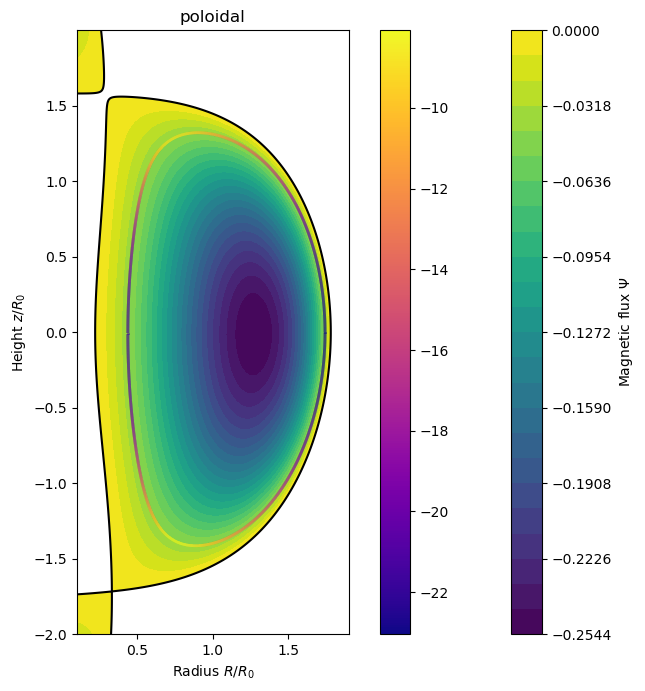

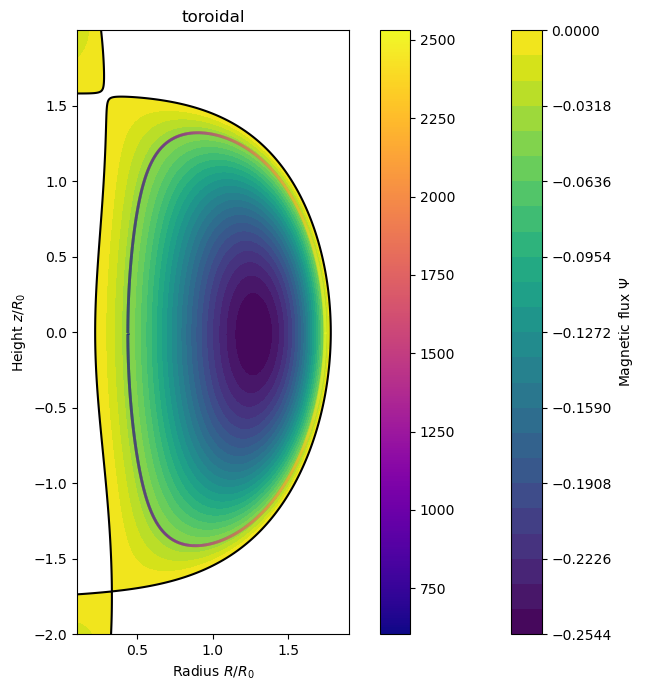

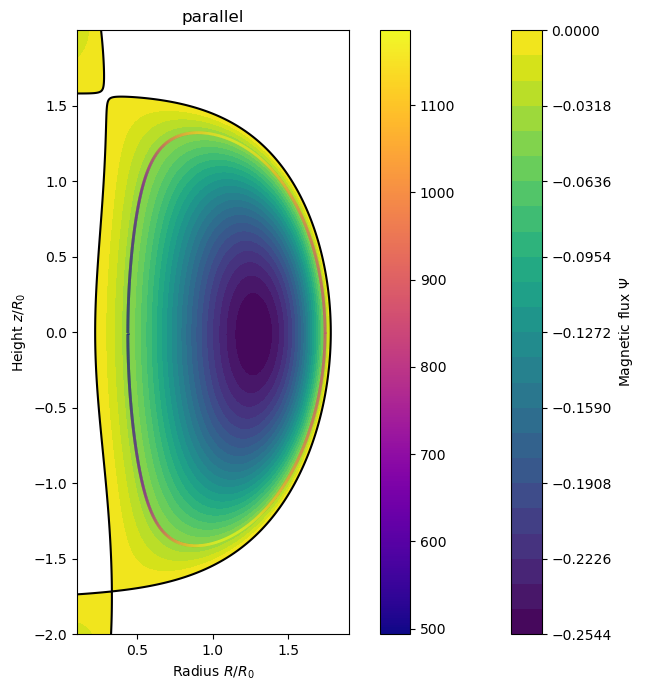

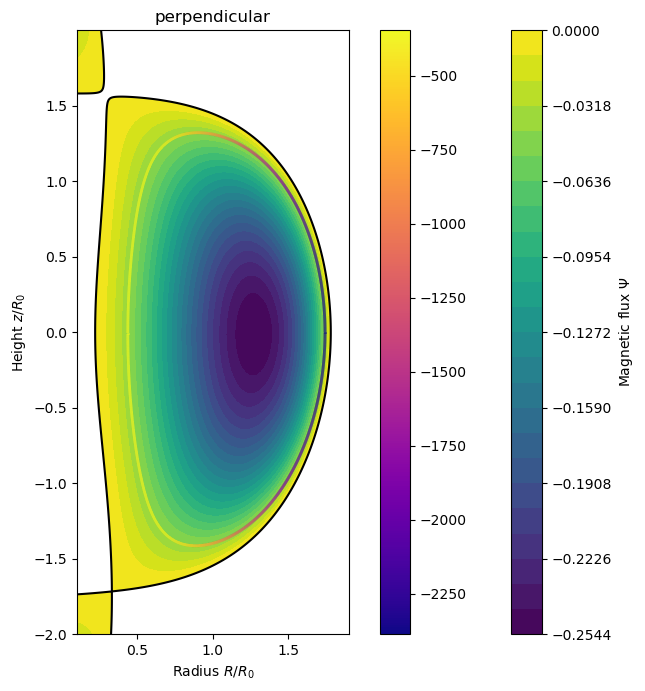

In [52]:
directions = ["poloidal", "toroidal", "parallel", "perpendicular"]
for index, label in enumerate(directions):
    ax = eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep)
    surfaces[-5].plot(ax, quantity =  fcs[-5].local_flow_velocities["H 1+"][index].value, legend=False)
    ax.set_title(label)

In [ ]:
for index, label in enumerate(directions):
    ax = eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep)
    for surface, fc in zip(surfaces, fcs):
        surface.plot(ax, quantity =  fc.local_flow_velocities["H 1+"][index].value, legend=False, colorbar=False)
    ax.set_title(label)